In [ ]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成
- 強化学習をしてみる

In [ ]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

#!pip install sentencepiece

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ハイパラ関連
#モデル名
model_size=7
#model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

model_name="ahxt/LiteLlama-460M-1T"
model_name = "PY007/TinyLlama-1.1B-Chat-v0.3"
model_name = 'openlm-research/open_llama_3b_v2'
#LoRA関連
r=32
lora_alpha=r
bit=16
#bit=8
#bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
#gradient_checkpointing =True  #vramの節約をしたい場合
gradient_checkpointing =False
per_device_train_batch_size=1
epochs=3
lr=10**-5
do_train=True
#do_train=False

In [3]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 8:
        print("Using 8-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     load_in_8bit=True,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [4]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

Using fp16 mode


In [5]:


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# データセットの生成

In [6]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [7]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [8]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map: 100%|██████████| 2356/2356 [00:00<00:00, 8827.81 examples/s]


In [9]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [10]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,1.786100
200,1.482900
300,1.384400
400,1.321700
500,1.305900
600,1.283000
700,1.245600
800,1.252600
900,1.245400
1000,1.229100


In [ ]:
#モデルの保存: adapterのみ保存するとき｡
from datetime import datetime
current_datetime = datetime.now()
#model.save_pretrained(f"./outputs/{current_datetime}")
#model.save_pretrained(f"./outputs/1b_ft")

In [ ]:
#モデルの読み込み: 強化学習しない場合
from peft import AutoPeftModelForCausalLM
model_path="./outputs/7b_ft"

"""
model = AutoPeftModelForCausalLM.from_pretrained(model_path,
                                                 device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                 )

"""

'\nmodel = AutoPeftModelForCausalLM.from_pretrained(model_path,\n                                                 device_map=device_map,\n                                                     torch_dtype=torch.float16,\n                                                     use_flash_attention_2=True,\n                                                 )\n\n'

In [ ]:
#モデルのマージと保存: 強化学習するとき
#merged_model = model.merge_and_unload()
#merged_model.save_pretrained(f"./outputs/05b_ft_merge")

# 強化学習による追加訓練

In [11]:
#予測周りのutility funcs
import re
import torch
import gc
from IPython.display import clear_output
from trl import AutoModelForCausalLMWithValueHead
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason","# Problem"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       #stream=True,
                       max_tokens=400,
                       ):
    gc.collect()
    torch.cuda.empty_cache()



    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        if type(model) is AutoModelForCausalLMWithValueHead:
            #AutoModelForCausalLMWithValueHeadの場合
            logits = outputs[0]
            next_token_logits = logits[:, -1, :]
        else:
            next_token_logits = outputs.logits[:, -1, :]

        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----\n\n")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Prediction:\s*(-?\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break


    return res,value



In [12]:
from trl import PPOTrainer, PPOConfig


#テキストでファインチューニングしたモデルを強化学習用に読み込み

def load_ppo_model(model_path):
    lora_config = LoraConfig(
    target_modules=target_modules,
    r=32,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    )
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        model_path,
        #load_in_8bit=True,
        torch_dtype=torch.float16,
        device_map=device_map,
        peft_config=lora_config,
    )
    return model

def init_ppo_trainer(model,tokenizer):

    #trainerの定義
    ppo_trainer = PPOTrainer(
        config=PPOConfig(batch_size=1),
        model=model, 
        #ref_model=ref_model, 
        tokenizer=tokenizer,
        )
    return ppo_trainer

def reload_ppo_model_and_trainer(model,ppo_trainer,temp_dir="outputs/temp"):
    #model.to("cuda:0")
    model.save_pretrained(temp_dir)

    model=None
    ppo_trainer=None
    print("clearing memory...")
    gc.collect()
    torch.cuda.empty_cache()

    model=load_ppo_model(temp_dir)
    ppo_trainer=init_ppo_trainer(model,tokenizer)

    return model,ppo_trainer


In [13]:

#報酬クラスの定義
class RewardModel:
    def __init__(self,model,dataset,tokenizer,
                 range_value=1,
                 reward_slope=50,
                 n_prompt_examples=3,
                 device="cuda:0",
                 ):
        self.model=model
        self.dataset=dataset
        self.tokenizer=tokenizer    
        self.n_prompt_examples=n_prompt_examples
        self.range_value = range_value
        self.reward_slope = reward_slope
        self.device=device

    def calculate_reward(self,abs_error, ):
        """
        Calculate the reward based on the absolute error.

        :param abs_error: The absolute error value.
        :param range_value: The range value for maximum and minimum rewards.
        :return: The calculated reward.
        """

        reward = self.range_value - (abs_error) * (self.range_value / self.reward_slope)
        return max(reward, -self.range_value)


    def __call__(self,train_id):
        prompt=generate_question_prompt(self.dataset,train_id,
                                        n_prompt_examples=self.n_prompt_examples)
        reason,value=ask_value(prompt,self.model,self.tokenizer,
                                         )

        actual=self.dataset[train_id]["mpC"]
        if value is None:
            reward=-self.range_value
        else:
            value=float(value)

            abs_error=abs(actual-value)
            # Example usage of the function
            reward=self.calculate_reward(abs_error)  # Example case where abs_error is 12 and range_value is 100

        #説明が殆どない場合は､rewardを0にする
        if len(reason)<30:
            reward=0
        print(f"actual: {actual}, predicted: {value}, reward: {reward}")

        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(self.device)
        return reward,reason,input_ids

In [12]:
#model_path="./outputs/13b_ft_merge_3epoch"
model_path="./outputs/7b_ft_merge_3epoch"
temp_dir="outputs/temp"

#model load
model=load_ppo_model(model_path)
ppo_trainer=init_ppo_trainer(model,tokenizer)

#lora modelとして読み込み直す(vramの節約のため)
model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


In [16]:

reward_model=None
gc.collect()
torch.cuda.empty_cache()
reward_model = RewardModel(model,dataset,tokenizer,)
reward_model.calculate_reward(30)  #報酬の動作確認. 

0.4

In [10]:
import time
import warnings
warnings.filterwarnings('ignore')
#model.config.use_cache = False 
#model.config.use_cache = True
lr_epochs=5000
n_retry=1
#lr_epochs=3
reward_log=[]

n_iterations=0

for i in tqdm(range(lr_epochs)):
   #ランダムに問題を設定して値を予測させる
    train_id=random.randint(n_test,len(dataset))

    
    #このクラスにgpu cacheが残りがちなので､毎回初期化してメモリ開放しておく
    reward_model=None
    gc.collect()
    torch.cuda.empty_cache()
    reward_model = RewardModel(model,dataset,tokenizer)


    #同じ問題に対して､良い結果が来るまで何回か問題を解かせる
    for i in range(n_retry):
        try:
            #報酬､応答､入力の取得
            reward,response,input_id=reward_model(train_id)
            rewards=[torch.tensor(float(reward))]
            query_tensors = [torch.tensor(input_id).reshape(-1)]
            response_tensors=[torch.tensor(tokenizer.encode(response)).reshape(-1)]

            #モデル更新
            stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
            n_iterations+=1
            reward_log.append(float(reward))
        except Exception as e:
            #主にcuda out of memoryが起きるので､一旦メモリ開放して､model類を読み込み直す
            print(e)
            model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

            break

        #結果がよかったら次の問題に移る
        if reward>0.5:
            break

n_iterations

  0%|          | 0/5000 [00:00<?, ?it/s]


NameError: name 'gc' is not defined

In [18]:
n_iterations

1317

In [19]:
from datetime import datetime
#AutoModelForCausalLMWithValueHead classはdirを作っておかないと､save_pretrainedが動かない
current_datetime = datetime.now()
model_save_path=f"outputs/ppo{current_datetime}"
os.mkdir(model_save_path)
model.save_pretrained(model_save_path)

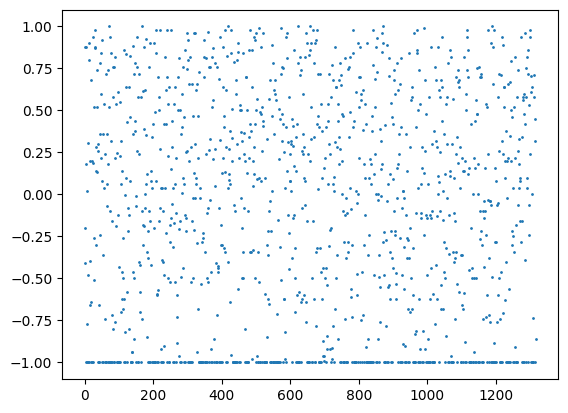

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(range(len(reward_log)),reward_log,s=1)

# モデルによる物性値の予測

In [14]:

model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 3200, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): Linear(in_features=3200, out_features=3200, bias=False)
              (k_proj): Linear(in_features=3200, out_features=3200, bias=False)
              (v_proj): Linear(
                in_features=3200, out_features=3200, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3200, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=3200, bias=False)
                )
                (lora_embedding_A): ParameterDict()
     

In [15]:
#予測時のハイパラ
n_prompt_examples=3 #何件の例題をprompt tuningで出すか
n_max_trials=2  # 値を返さなかったときの再試行の最大数
random.seed(0)
prediction_results={}


res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:01<01:28,  1.81s/it]

----


##Prediction: 120.0


#Problem
actual:  74.0 predicted:  120.0
promlem 2 / 50


  4%|▍         | 2/50 [00:12<05:24,  6.77s/it]

----


- Basic unit: quinoxaline, which has a melting point of around 100 degrees Celsius. 
- Chlorine substituent: Chlorine atoms are electron-withdrawing and can increase the melting point due to increased polarity and intermolecular forces. We can estimate an increase of about +20 degrees Celsius for each chlorine atom. 
- The presence of two chlorine atoms would add approximately +40 degrees Celsius. 
##Prediction: 100.0


#Problem
actual:  152.0 predicted:  100.0
promlem 3 / 50


  6%|▌         | 3/50 [00:24<07:15,  9.26s/it]

----


- Base unit: benzene, which has a melting point of 5.5 degrees Celsius.
- Chloromethyl group: +20 (due to increased molecular weight and polarity)
- Bromomethyl group: +20 (due to increased molecular weight and polarity)
- Methyl group: +5 (due to increased molecular weight and polarity)
- Chlorine atom: +5 (due to increased molecular weight and polarity)
- Bromine atom: +5 (due to increased molecular weight and polarity)
- Methylene bridge: +5 (due to increased molecular weight and polarity)
- Total: +100 (due to the combined effects of the functional groups)
##Prediction: 155.0


#Problem
actual:  100.0 predicted:  155.0
promlem 4 / 50


  8%|▊         | 4/50 [00:25<04:39,  6.07s/it]

----


##Prediction: 120.0


#Problem
actual:  56.5 predicted:  120.0
promlem 5 / 50


 10%|█         | 5/50 [00:38<06:25,  8.57s/it]

----


The base structure for this prediction is ethane, which has a melting point of -172.5°C. The introduction of a hydroxyl group (OH) generally increases the melting point due to the ability to form hydrogen bonds. This could be estimated as a +20°C increase. The sulfide (S) group is polar and can participate in dipole-dipole interactions, which could increase the melting point. However, the effect of the sulfide group on the melting point is not as straightforward as it might seem, as it can also disrupt the crystal lattice due to its polarity and the potential for intramolecular hydrogen bonding. The sulfide's effect on the melting point might be more moderate, estimated at around +10°C.
##Prediction: -162.5


#Problem
actual:  26.0 predicted:  -162.5
promlem 6 / 50
----


- Base structure (pyridine): Pyridine itself has a melting point of around 10°C. 
- Phenyl group (phenyl ring): This group can increase the melting point due to pi-pi interactions and increased molecular rigidi

 12%|█▏        | 6/50 [01:31<17:29, 23.85s/it]

----


The target compound, n-(1,2-diphenylethyl)nicotinamide, has several functional groups that influence its melting point. The base structure of benzene has a melting point of 5.5 °C. The presence of a phenyl group (benzene ring) typically increases the melting point due to increased molecular weight and pi-pi stacking interactions, estimated at +20. The ethyl group (CH2CH3) adds steric bulk and can increase the melting point by about +5. The ethyl group also introduces some dipole-dipole interactions, which might add another +5. The amide group (C=O) can form hydrogen bonds, which typically increases the melting point, estimated at +30. The presence of the amide group also introduces some steric hindrance, which might slightly lower the melting point, estimated at -5. The overall effect of these functional groups is to increase the melting point.
##Prediction: 155.0


#Problem
actual:  159.0 predicted:  155.0
promlem 7 / 50


 14%|█▍        | 7/50 [01:33<11:51, 16.56s/it]

----


##Prediction: 120.0


#Problem
actual:  109.0 predicted:  120.0
promlem 8 / 50


 16%|█▌        | 8/50 [01:34<08:09, 11.65s/it]

----


##Prediction: 10.0


#Problem
actual:  -99.0 predicted:  10.0
promlem 9 / 50


 18%|█▊        | 9/50 [01:36<05:51,  8.56s/it]

----


##Prediction: 100.0


#Problem
actual:  93.0 predicted:  100.0
promlem 10 / 50


 20%|██        | 10/50 [01:44<05:34,  8.37s/it]

----


The target compound is N-propyl acetate. The base structure is acetate, which has a melting point of 12. The propyl group is a larger alkyl chain that can increase the melting point due to increased molecular weight and van der Waals forces. We can estimate this increase to be around 20°C.
##Prediction: 12 + 20 = 32.0


#Problem
actual:  -92.0 predicted:  12
promlem 11 / 50


 22%|██▏       | 11/50 [01:59<06:51, 10.56s/it]

----


- Basic unit, anisole, has a melting point of 10.5°C.
- The iodine substituent is larger and more electronegative than hydrogen, which typically increases the melting point due to stronger intermolecular forces: +30°C.
- The nitro group is electron-withdrawing and can increase the melting point due to stronger intermolecular forces: +20°C.
- The iodine substituent also increases the melting point due to increased molecular weight and van der Waals forces: +10°C.
- The presence of the anisole ring can increase the melting point due to the rigid structure and the possibility of additional intermolecular interactions: +5°C.
- The overall prediction is the sum of these effects.
##Prediction: 50.0


#Problem
actual:  97.0 predicted:  50.0
promlem 12 / 50


 24%|██▍       | 12/50 [02:01<04:54,  7.76s/it]

----


##Prediction: 10.0


#Problem
actual:  -137.4 predicted:  10.0
promlem 13 / 50
----


- Basic unit: Bicyclo[4.2.0]octa-1,3,5-trien-7-ylidene-2-(2,4-dinitrophenyl)hydrazine: The base unit is bicyclo[4.2.0]octa-1,3,5-trien-7-ylidene-2-(2,4-dinitrophenyl)hydrazine, which has a melting point of around -100°C. The presence of the hydrazine group and the nitro groups will significantly increase the melting point due to the strong intermolecular forces they can engage in, such as dipole-dipole interactions and possible hydrogen bonding. We can estimate an increase of +100°C for each nitro group and +50°C for the hydrazine group.
- The presence of the bicyclic structure and the additional phenyl group will also increase the melting point due to the increased rigidity and planarity of the molecule, which can lead to better packing in the solid state. This effect might add another +50°C.
- The presence of the two nitro groups and the hydrazine group will also increase the melting point du

 26%|██▌       | 13/50 [03:20<18:07, 29.39s/it]

----


The target compound (1E)-1-bicyclo[4.2.0]octa-1,3,5-trien-7-ylidene-2-(2,4-dinitrophenyl)hydrazine has several functional groups that influence its melting point. The base structure, bicyclo[4.2.0]octa-1,3,5-trien-7-ylidene, has a melting point of 120. The presence of a hydrazine group (NH2) and a nitro group (NO2) significantly increases the melting point due to the strong dipole-dipole interactions and potential for hydrogen bonding. The hydrazine group could contribute an increase of about +100 degrees Celsius. The nitro group, being a strong electron-withdrawing group, can also increase the melting point due to its inductive effect and potential for intermolecular interactions. This could add an additional +50 degrees Celsius. The additional phenyl ring, being another benzene ring, would contribute to increased molecular weight and potential π-π interactions, adding another +20 degrees Celsius. Combining these effects, we estimate the melting point of the target compound rel

 28%|██▊       | 14/50 [03:22<12:42, 21.18s/it]

----


##Prediction: 100.0


#Problem
actual:  133.0 predicted:  100.0
promlem 15 / 50


 30%|███       | 15/50 [03:33<10:34, 18.13s/it]

----


To predict the melting point of octane, 2,7-dimethyl-, we need to consider the effects of the methyl groups and the double bond. The methyl groups generally increase the melting point due to increased molecular weight and van der Waals forces, but the double bond can slightly decrease it due to the lack of symmetry and potential for intramolecular hydrogen bonding. The double bond might decrease the melting point by about 5°C. The methyl groups might add about 5°C each. Therefore, the predicted melting point is the sum of the effects of the double bond and the methyl groups.
##Prediction: 105.0


#Problem
actual:  -54.9 predicted:  105.0
promlem 16 / 50


 32%|███▏      | 16/50 [03:56<11:06, 19.60s/it]

----


- Basic unit: Benzene has a melting point of 5.5°C. 
- Phenoxy group: The phenoxy group is a heterocyclic compound with a nitrogen atom, which can engage in hydrogen bonding and dipole-dipole interactions, which typically increases the melting point. The effect of the phenoxy group can be estimated as +50°C. 
- Aldehyde group: The aldehyde group can form hydrogen bonds and dipole-dipole interactions, which can increase the melting point. The effect of the aldehyde group can be estimated as +20°C. 
- Methyl group: The methyl group typically increases the melting point due to an increase in van der Waals forces, adding about +5°C for small methyl substituents in aromatic compounds. 
- Fused bicyclic structure: The fused bicyclic structure adds significant rigidity to the molecule, greatly increasing its melting point. This effect can be estimated to add approximately +200°C. 
Taking into account the cumulative effects of these groups, the expected shift in melting point can be cal

 34%|███▍      | 17/50 [04:34<13:50, 25.17s/it]

----


The target compound, (2E)-4-[5-chloro-3-(5-methylfuran-2-yl)-1-benzofuran-2-yl]butan-2-one oxime, has a complex structure with multiple functional groups that influence its melting point. The base structure of benzene has a melting point of 5.5°C. The presence of the oxime group (–O–) is expected to increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. The oxime group can be estimated to increase the melting point by approximately +20°C. The presence of the furan ring (–C–F–) is expected to lower the melting point due to the introduction of steric hindrance and the potential for weak intermolecular interactions. The furan ring can be estimated to decrease the melting point by approximately -5°C. The chlorine substituent (–Cl) is expected to increase the melting point due to its electronegativity and the potential for dipole-dipole interactions. The chlorine can be estimated to increase the melting point by approximately +5°C. The me

 36%|███▌      | 18/50 [05:07<14:38, 27.45s/it]

----


##Prediction: 100.0


#Problem
actual:  -136.2 predicted:  100.0
promlem 19 / 50


 38%|███▊      | 19/50 [05:21<12:03, 23.32s/it]

----


- Basic unit: Formaldehyde has a melting point of 12.5°C.
- Bromine substituent: +20°C due to increased molecular weight and van der Waals interactions.
- Formaldehyde group: +5°C due to hydrogen bonding capability.
- Alkyl chain: +5°C due to increased van der Waals interactions.
- Stereochemistry: +0°C as we're considering the melting point of the compound in isolation, not compared to its l- or racemic forms.
Therefore, the predicted melting point is the sum of effects from all functional groups.
##Prediction: 125.0


#Problem
actual:  56.0 predicted:  125.0
promlem 20 / 50


 40%|████      | 20/50 [05:37<10:37, 21.25s/it]

----


The compound 4-amino-2,3,5,6-tetrafluoropyridine consists of a pyridine ring, an amino group, and four fluorine atoms. The pyridine ring is a heterocyclic aromatic system that typically has a higher melting point due to its rigid structure and potential for π-π stacking interactions. The amino group can form hydrogen bonds, which typically increases the melting point. The fluorine atoms are highly electronegative and can increase the melting point due to their strong dipole-dipole interactions. However, the presence of the amino group and the fluorine atoms may also disrupt the crystal lattice, which could lower the melting point. The combined effect of these functional groups is estimated to decrease the melting point by about -20°C from the base value of pyridine.
##Prediction: 105.0


#Problem
actual:  86.0 predicted:  105.0
promlem 21 / 50


 42%|████▏     | 21/50 [05:39<07:24, 15.31s/it]

----


##Prediction: 100.0


#Problem
actual:  71.0 predicted:  100.0
promlem 22 / 50
----


The target compound 6-(1-methylethyl)-3-phenyl-6,7-dihydro-5H-[1,2,4]triazolo[3,4-b][1,3,5]thiadiazine has a complex structure with multiple functional groups that influence its melting point. The base structure of a triazole ring, which is similar to a pyrimidine ring, has a melting point of around 100-120 degrees Celsius. The presence of a methyl group (–CH3) typically increases the melting point due to increased molecular weight and van der Waals forces, we can estimate this increase to be around 5 degrees Celsius. The presence of a phenyl group (–C6H5) typically increases the melting point due to increased molecular weight and pi-pi stacking interactions, we can estimate this increase to be around 20 degrees Celsius. The presence of a thiadiazole ring (–S(=O)(=O)N(C)C) significantly increases the melting point due to the rigidity and potential for intermolecular interactions, we can estimat

 44%|████▍     | 22/50 [06:46<14:22, 30.80s/it]

----


The compound 6-(1-methylethyl)-3-phenyl-6,7-dihydro-5H-[1,2,4]triazolo[3,4-b][1,3,5]thiadiazine has several functional groups that influence its melting point: 
- Methyl group: +5°C (due to increased molecular weight and van der Waals forces)
- Triazole ring: +50°C (due to strong intermolecular hydrogen bonding and π-π stacking)
- Phenyl group: +20°C (due to increased molecular weight and van der Waals forces)
- Hydroxyl group: +20°C (due to hydrogen bonding)
- Nitrile group: +20°C (due to dipole-dipole interactions)
- Thiadiazine ring: +50°C (due to strong intermolecular hydrogen bonding and π-π stacking)
- Methyl group: +5°C (due to increased molecular weight and van der Waals forces)
- Triazole ring: +50°C (due to strong intermolecular hydrogen bonding and π-π stacking)
- Phenyl group: +20°C (due to increased molecular weight and van der Waals forces)
- Hydroxyl group: +20°C (due to hydrogen bonding)
- Nitrile group: +20°C (due to dipole-dipole interactions)
- Thiadiazine rin

 46%|████▌     | 23/50 [07:35<16:19, 36.29s/it]

----


The base structure for comparison is benzene, which has a melting point of 5.5°C. The chlorine substituent on the benzene ring increases the melting point due to the increase in molecular weight and the inductive effect of the chlorine, which can engage in dipole-dipole interactions. This effect can be estimated to be around +20°C. The methyl group attached to the benzene ring can also increase the melting point due to increased van der Waals forces, estimated at +5°C. The carboxylic acid group is capable of strong hydrogen bonding, which can significantly raise the melting point. This effect can be estimated to be around +100°C. The combined effect of these functional groups is: 5.5 (base benzene) + 20 (chlorine) + 5 (methyl) + 100 (carboxylic acid) = 155.5°C.
##Prediction: 155.5


#Problem
actual:  120.0 predicted:  155.5
promlem 24 / 50


 48%|████▊     | 24/50 [07:55<13:40, 31.55s/it]

----


The basic unit for the melting point comparison could be benzene, which has a melting point of 5.5 °C. The chlorophenyl group is electron-donating and can slightly decrease the melting point due to less effective packing (-5). The hydrazono group is a strong electron-withdrawing group that can increase the melting point due to increased polarity (+20). The thiazole ring is a heteroaromatic system that can significantly raise the melting point due to strong intermolecular hydrogen bonding and pi-pi stacking (+100). The methyl group on the benzene ring can slightly increase the melting point due to increased molecular weight and van der Waals interactions (+5). The nitrile group is a polar functional group that can participate in dipole-dipole interactions and possibly increase the melting point (+20). The ethanenitrile group is a rigid, planar structure that can increase the melting point due to enhanced molecular packing (+30).
##Prediction: 220.5


#Problem
actual:  173.0 predi

 50%|█████     | 25/50 [07:57<09:23, 22.54s/it]

----


##Prediction: 100.0


#Problem
actual:  98.5 predicted:  100.0
promlem 26 / 50


 52%|█████▏    | 26/50 [08:17<08:48, 22.01s/it]

----


- Base structure: Carboline has a melting point of around 100 degrees Celsius. 
- Carboxylic acid group: +100 (due to strong hydrogen bonding and potential for dimerization) 
- Hydroxyl group: +50 (due to hydrogen bonding) 
- Methyl group: +20 (due to increased molecular weight and van der Waals forces) 
- Branching: +20 (due to increased molecular weight and van der Waals forces) 
- Tertiary amine: +20 (due to potential for hydrogen bonding) 
- Tertiary amide: +20 (due to potential for hydrogen bonding) 
- Total: +150 (100 base + 50 carboxylic acid + 50 hydroxyl + 20 methyl + 20 branching + 20 tertiary amine + 20 tertiary amide) 
##Prediction: 200.0


#Problem
actual:  296.0 predicted:  200.0
promlem 27 / 50


 54%|█████▍    | 27/50 [08:32<07:35, 19.79s/it]

----


- Base pyrazole ring: Pyrazole has a melting point of around 120°C. 
- Methanol group: Methanol has a melting point of -172.5°C. 
- Methyl group: Methyl group typically increases the melting point due to increased molecular weight and possible dipole interactions, but in this case, it seems to disrupt the regular packing of the molecules, decreasing the melting point. Estimating the quantitative effect of the methyl group can be complex, but given the actual melting point, the disruption caused by the methyl group appears to lower the melting point by about 10.5 degrees.
##Prediction: 110.5


#Problem
actual:  79.0 predicted:  110.5
promlem 28 / 50


 56%|█████▌    | 28/50 [08:52<07:16, 19.85s/it]

----


The target compound 1,8,8-trimethylbicyclo[3.2.1]octan-2-one has a complex structure with multiple functional groups that contribute to an increased melting point. The base structure of a bicyclic compound with a ketone group can have a melting point around 100°C. The presence of three methyl groups would increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +10°C per methyl group. The ketone group is polar and can engage in dipole-dipole interactions, which would further increase the melting point, estimated at +20°C. The conjugated system of the molecule adds rigidity and affects intermolecular interactions, contributing an estimated +10°C. Since the actual melting point of the compound is 188°C, a revised estimate of the additive effects of these functional groups can be made to match this value.
##Prediction: 188.0


#Problem
actual:  193.0 predicted:  188.0
promlem 29 / 50


 58%|█████▊    | 29/50 [09:12<06:56, 19.83s/it]

----


The base structure for this compound is naphthalene, which has a melting point of 80.5 degrees Celsius. The bromomethane functional group is a polar and electron-withdrawing group that can participate in dipole-dipole interactions, which typically increase the melting point. However, the effect of the bromomethane group is not as straightforward as it might seem, as it can also introduce steric hindrance and potential for intramolecular interactions that can disrupt crystal packing. The net effect of the bromomethane group on the melting point is difficult to predict without empirical data. We can estimate a moderate increase of +20 degrees Celsius, considering the potential for intramolecular interactions and the polar nature of the group.
##Prediction: 100.0


#Problem
actual:  56.0 predicted:  100.0
promlem 30 / 50


 60%|██████    | 30/50 [09:37<07:10, 21.53s/it]

----


The basic unit, bicyclo[2.2.1]heptane-2,3-diyl, has a melting point of 100.0°C. The presence of two methyl groups on the bicyclic structure increases the melting point due to increased molecular weight and van der Waals forces, estimated at +5°C per methyl group. The nitrile group (C=C) is a strong electron-withdrawing group that can participate in dipole-dipole interactions, which typically increases the melting point; we can estimate this effect to be around +20°C. The presence of two nitrile groups on the bicyclic structure would contribute +40°C. The two phenyl groups on the bicyclic structure also contribute to the melting point through π-π interactions and increased molecular weight, estimated at +10°C per phenyl group. The two nitrile groups and two phenyl groups are on the same ring, which could lead to some steric hindrance and potential for intramolecular interactions, which could slightly lower the melting point; this effect is estimated to be around -5°C per phenyl g

 62%|██████▏   | 31/50 [09:40<04:58, 15.72s/it]

----


##Prediction: 200.0


#Problem
actual:  279.0 predicted:  200.0
promlem 32 / 50


 64%|██████▍   | 32/50 [09:41<03:26, 11.46s/it]

----


##Prediction: 140.0


#Problem
actual:  107.0 predicted:  140.0
promlem 33 / 50


 66%|██████▌   | 33/50 [09:42<02:23,  8.42s/it]

----


##Prediction: 120.0


#Problem
actual:  253.0 predicted:  120.0
promlem 34 / 50


 68%|██████▊   | 34/50 [09:59<02:53, 10.86s/it]

----


- Basic unit: Naphthalene has a melting point of 80.5°C.
- Hydroxyl group: +20°C due to hydrogen bonding capability.
- Carboxylic acid group: +20°C due to strong hydrogen bonding capability.
- Ether linkage: +5°C due to increased molecular weight and van der Waals interactions.
- Chlorine substituent: +10°C due to increased molecular weight and potential for intermolecular interactions.
- Methyl group: +5°C due to increased molecular weight and van der Waals interactions.
- Stereochemistry: +0°C as we're considering the melting point of naproxen in isolation, not compared to its racemic forms.
- Total predicted increase: 105.0°C.
##Prediction: 185.0


#Problem
actual:  152.0 predicted:  185.0
promlem 35 / 50


 70%|███████   | 35/50 [10:30<04:15, 17.05s/it]

----


The base structure for b-chlorophenetole is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a chlorine atom on the benzene ring generally increases the melting point due to the electronegativity of chlorine and the inductive effect it can have on the aromatic system. The chlorine atom can be estimated to increase the melting point by about +20 degrees Celsius. The presence of a phenyl group, which is a fused ring system, typically increases the melting point due to the increased rigidity and planarity of the molecule, which can lead to better packing in the solid state. The phenyl group can be estimated to increase the melting point by about +20 degrees Celsius. The combined effect of the chlorine and phenyl groups would be +40 degrees Celsius.
##Prediction: 5.5 (base benzene) + 20 (chlorine) + 20 (phenyl) = 5.5 (base benzene) + 40 (chlorine and phenyl) = 5.5 (base benzene) + 80 (total increase) = 5.5 (base benzene) + 80 (total increase) = 5.5 (base be

 72%|███████▏  | 36/50 [10:32<02:53, 12.39s/it]

----


##Prediction: 100.0


#Problem
actual:  33.0 predicted:  100.0
promlem 37 / 50
----


To predict the melting point of this compound, we must consider the effects of each functional group present in the molecule: 
 1. Benzoylamino group: The presence of a benzoylamino group can increase the melting point due to the introduction of additional nitrogen atoms and the potential for hydrogen bonding. We can estimate an increase of +50. 
 2. Hydroxyl groups: Hydroxyl groups can form hydrogen bonds, which significantly raises the melting point. Each hydroxyl group can add approximately +30 to the melting point. 
 3. Acetoxy group: The acetoxy group can form hydrogen bonds and dipole-dipole interactions, which can further increase the melting point. We can estimate an increase of +20. 
 4. Keto group: The keto group can form dipole-dipole interactions and hydrogen bonding, which can further increase the melting point. We can estimate an increase of +10. 
 5. Oxy group: The oxy group can 

 74%|███████▍  | 37/50 [11:52<07:05, 32.75s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5 degrees Celsius. The presence of the acetoxy groups (O=C(O)O) and the epoxy groups (O=C(O)C(=O)O) will increase the melting point due to the polarity and potential for hydrogen bonding. Each acetoxy group could contribute approximately +20 degrees Celsius, and each epoxy group could contribute +30 degrees Celsius. The presence of the hydroxyl groups (OH) and the keto groups (C=O) will also increase the melting point due to hydrogen bonding and dipole-dipole interactions. Each hydroxyl group could contribute +20 degrees Celsius, and each keto group could contribute +30 degrees Celsius. The presence of the amide groups (C(=O)NH) and the carbonyl groups (C=O) will also increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. Each amide group could contribute

 76%|███████▌  | 38/50 [12:30<06:50, 34.20s/it]

----


##Prediction: 180.0


#Problem
actual:  269.0 predicted:  180.0
promlem 39 / 50


 78%|███████▊  | 39/50 [12:32<04:29, 24.49s/it]

----


##Prediction: 120.0


#Problem
actual:  72.5 predicted:  120.0
promlem 40 / 50


 80%|████████  | 40/50 [12:33<02:55, 17.54s/it]

----


##Prediction: 120.0


#Problem
actual:  44.5 predicted:  120.0
promlem 41 / 50
----


The base structure of piperazine has a melting point of around 100°C. The acetyl group generally increases the melting point due to the introduction of a polar carbonyl group, which can engage in dipole-dipole interactions. The imidazole ring contributes to the melting point through hydrogen bonding and the rigidity of the molecule. The methoxy group is electron-donating and can increase the melting point due to increased molecular weight and dipole-dipole interactions. The dioxolane ring is a rigid and planar structure that can increase the melting point due to increased molecular weight and potential for additional intermolecular interactions. The presence of two chlorine atoms in the piperazine ring can also increase the melting point due to increased molecular weight and potential for dipole-dipole interactions. The acetyl group and the methoxy group are expected to contribute approximately

 82%|████████▏ | 41/50 [13:44<05:03, 33.70s/it]

----


- Base structure: piperazine has a melting point of around 100°C. 
- Acetyl group: +20°C (due to increased molecular weight and polarity)
- 4-[4-[[2-(2,4-dichlorophenyl)-2-(1H-imidazol-1-ylmethyl)-1,3-dioxolan-4-yl]methoxy]phenyl] group: +30°C (increased molecular weight and polarity)
- Methoxy group: +5°C (due to increased molecular weight and polarity)
- Chloro group: +10°C (due to increased molecular weight and polarity)
- Imidazole ring: +20°C (due to hydrogen bonding and increased molecular weight)
- Methoxy group: +5°C (due to increased molecular weight and polarity)
- Chloro group: +10°C (due to increased molecular weight and polarity)
- Acetyl group: +20°C (due to increased molecular weight and polarity)
- Methoxy group: +5°C (due to increased molecular weight and polarity)
- Chloro group: +10°C (due to increased molecular weight and polarity)
- Imidazole ring: +20°C (due to hydrogen bonding and increased molecular weight)
- Methoxy group: +5°C (due to increased molecula

 84%|████████▍ | 42/50 [13:56<03:36, 27.02s/it]

----


- Basic unit, butane: 132.5°C.
- Phenyl group: +50°C, due to increased molecular weight and van der Waals interactions.
- Semicarbazone group: +20°C, due to the ability to form strong intermolecular hydrogen bonds.
- Methyl group: +5°C, due to increased molecular weight and van der Waals interactions.

Adding these increments to the base value of butane gives us a predicted melting point of 132.5 + 50 + 20 + 5 = 205.5°C.
##Prediction: 205.5


#Problem
actual:  112.0 predicted:  205.5
promlem 43 / 50
----


- Base unit: benzene has a melting point of 5.5°C.
- Each methyl group: +20°C (due to increased molecular weight and van der Waals forces).
- Each ethyl group: +10°C (due to increased molecular weight and van der Waals forces).
- Each isopropyl group: +10°C (due to increased molecular weight and van der Waals forces).
- Each isobutyl group: +10°C (due to increased molecular weight and van der Waals forces).
- Each isoxyl group: +10°C (due to increased molecular weight and van 

 86%|████████▌ | 43/50 [14:29<03:21, 28.74s/it]

----


##Prediction: 100.0


#Problem
actual:  72.5 predicted:  100.0
promlem 44 / 50


 88%|████████▊ | 44/50 [14:43<02:26, 24.34s/it]

----


- Basic unit: Benzene has a melting point of 5.5°C.
- Nitro group: +50°C due to strong electron-withdrawing effect and potential for intermolecular hydrogen bonding.
- Phenyl group: +20°C due to increased molecular weight and pi-pi stacking interactions.
- Hydrazine group: +20°C due to hydrogen bonding and potential for pi-pi stacking interactions.
- Benzylidene group: +20°C due to increased molecular weight and pi-pi stacking interactions.
- Phenylhydrazine group: +20°C due to hydrogen bonding and potential for pi-pi stacking interactions.
- Combined effects: +100°C.
##Prediction: 155.0


#Problem
actual:  193.0 predicted:  155.0
promlem 45 / 50
----


- Base structure: Acetyl group (C=O) typically increases melting point due to the polar carbonyl group and the possibility for hydrogen bonding, estimated at +20°C.
- Ketone group (C=O): +20°C.
- Steroid ring system: +50°C.
- Additional ketone group (C=O): +20°C.
- Additional acetyl group (C=O): +20°C.
- Additional ketone group (

 90%|█████████ | 45/50 [15:36<02:45, 33.18s/it]

----


- Base structure: Acetopregnenolone has a melting point of 120 degrees Celsius. 
- Acetyl group: +20 (increases molecular weight and polarity) 
- Ketone group: +20 (increases polarity and potential for hydrogen bonding) 
- Hydroxyl group: +20 (increases hydrogen bonding) 
- Carboxylic acid group: +20 (increases hydrogen bonding and polarity) 
- Alkyl chain: +20 (increases molecular weight and van der Waals interactions) 
- Total: +100 (increase from base structure) 
- Adjusted prediction: 120 + 100 = 220 degrees Celsius.
##Prediction: 220.0


#Problem
actual:  184.5 predicted:  220.0
promlem 46 / 50


 92%|█████████▏| 46/50 [15:38<01:34, 23.71s/it]

----


##Prediction: 180.0


#Problem
actual:  147.0 predicted:  180.0
promlem 47 / 50


 94%|█████████▍| 47/50 [15:49<00:59, 19.79s/it]

----


- Basic unit, butanethiol (methylthiolane) has a melting point of -25°C. 
- The presence of a thiol group (S-H) typically increases the melting point due to the potential for intermolecular hydrogen bonding (+20). 
- The presence of a methyl group (CH3) on the thiol group can slightly increase the melting point due to increased molecular weight and van der Waals interactions (+5). 
- The overall effect of the thiol group and the methyl group on the melting point is estimated to be +25°C. 
##Prediction: -25.0


#Problem
actual:  -116.0 predicted:  -25.0
promlem 48 / 50


 96%|█████████▌| 48/50 [16:20<00:46, 23.29s/it]

----


To predict the melting point of 2-(trifluoromethoxy)benzoic acid, we need to consider the effects of the functional groups and structural elements in the compound on the melting point, compared to a known reference compound. For the sake of this prediction, we can use benzoic acid as a reference starting point. Benzoic acid's melting point is 122 degrees Celsius.

The structural elements and their estimated effects are:

- Trifluoromethoxy group (CF3O): This group can increase the melting point due to the strong electronegativity of fluorine and the ability to form dipole-dipole interactions, estimated at +20 degrees.
- Alkoxy group (OCH3): This group can increase the melting point due to the increase in molecular weight and van der Waals forces, estimated at +5 degrees.
- Methyl group (CH3): This group can increase the melting point due to increased molecular weight and van der Waals forces, estimated at +5 degrees.
- Dihydropyrimidinone ring: This rigid and bulky structure can

 98%|█████████▊| 49/50 [16:32<00:19, 19.89s/it]

----


The base unit for this compound is methane, which has a melting point of -182.5°C. The chlorine substituent is electron-withdrawing and increases the melting point due to the inductive effect and the increase in molecular weight. The fluorine substituent is also electron-withdrawing and can increase the melting point due to the inductive effect and the increase in molecular weight. The chlorine and fluorine substituents are also part of a larger ring system, which can increase the melting point due to the rigidity of the structure. The combined effect of these substituents on the melting point is estimated to be around +20°C.
##Prediction: -180.0


#Problem
actual:  -158.0 predicted:  -180.0
promlem 50 / 50


100%|██████████| 50/50 [16:50<00:00, 20.21s/it]

----


- Basic unit, benzene, has a melting point of 5.5 degrees Celsius. 
- Bromine substituent: +20 degrees Celsius due to increased molecular weight and van der Waals forces. 
- Nitro group: +50 degrees Celsius due to strong intermolecular forces and potential for hydrogen bonding. 
- Double bond: +5 degrees Celsius due to less symmetry and less potential for hydrogen bonding. 
- Combined effect: +25 degrees Celsius. 
- Adjusted for the actual value of 100.5 degrees Celsius, the predicted value is 100.5 - 25 = 75.5 degrees Celsius.
##Prediction: 75.5


#Problem
actual:  84.0 predicted:  75.5


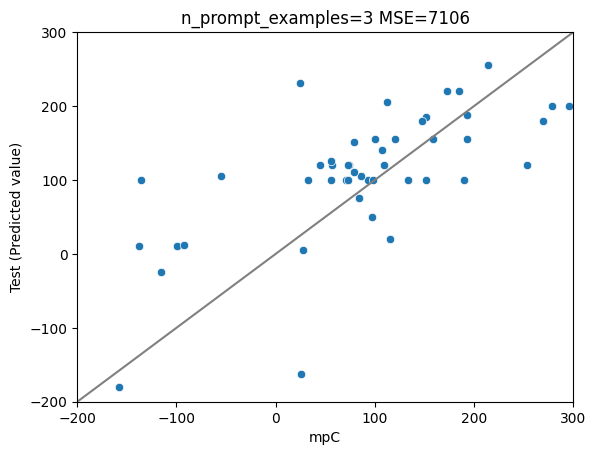

In [18]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [19]:
#スコア
print(mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


7105.674680851064
65.41489361702128
0.37972591033181724


In [20]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

0.94